# Approximate(Deep) Q-Learning
## Using TF-1.x
## Using Experience replay
### Tested on LunarLander-v2

##### Tried an oop approach, but I am not sure about TF1 graph flows

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Start the environment
env = gym.make("LunarLander-v2").env

## TF Stuff to do beforehand

In [3]:
#TF stuff
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import tensorflow.compat.v1.keras as keras
import tensorflow.compat.v1.keras.layers as L
tf.reset_default_graph()
sess = tf.InteractiveSession()
keras.backend.set_session(sess)

Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
#Checking GPU Use
if tf.test.gpu_device_name(): 

    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

Default GPU Device:/device:GPU:0


## Create AQL Agent

### The loss function for our agent is defined as - 
$$ L = { 1 \over N} \sum_i (Q_{\theta}(s,a) - [r(s,a) + \gamma \cdot max_{a'} Q_{-}(s', a')]) ^2 $$

Where
* $s, a, r, s'$ are current state, action, reward and next state respectively
* $\gamma$ is a discount factor defined two cells above.

Since $Q_{-}(s',a')$ is kept constant for our semi-grad Q-Learning, we will use `tf.stop_gradient` for this

## This version has -  
### 1. Experience replay buffer -
To reduce the problem of correlated samples
### 2. Target network -
To reduce the problem of policy oscillations and error propagation

In [5]:
class AQLAgent:
    def __init__(self, env, epsilon=0.5, gamma=0.99, buffer_size=0, target_network=False):
        '''
        Use load=True to load a previously saved model
        '''
        #Set up constants
        self.state_dim = env.observation_space.shape
        self.n_actions = env.action_space.n
        self.gamma = gamma
        self.epsilon = epsilon
        self.env = env
        self.buffer = None
        
        #Set up model
        self.model = self.create_model()
        #Print out some details
        print(self.model.summary())
        
        #Placeholders for <s,a,r,s'> and game_end
        self.states_ph = keras.backend.placeholder(dtype='float32', shape=(None,) + self.state_dim)
        self.actions_ph = keras.backend.placeholder(dtype='int32', shape=[None])
        self.rewards_ph = keras.backend.placeholder(dtype='float32', shape=[None])
        self.next_states_ph = keras.backend.placeholder(dtype='float32', shape=(None,) + self.state_dim)
        self.is_done_ph = keras.backend.placeholder(dtype='bool', shape=[None])
        
        #Then performing Q-Learning we have
        
        #Get 𝑄𝜃(s,a)
        self.pred_q = self.model(self.states_ph)
        self.pred_q_for_a = tf.reduce_sum(self.pred_q * tf.one_hot(self.actions_ph, self.n_actions), axis=1)
        
        #Get Q_(s',a')
        self.pred_next_q = self.model(self.next_states_ph)
        #Get V_(s',a') using Q
        self.next_v = tf.math.reduce_max(self.pred_next_q, axis=1)
        #Get target Q-value, Q_(s',a')
        self.target_q_for_a = self.rewards_ph + self.gamma*self.next_v
        # at the last state we shall use simplified formula: Q(s,a) = r(s,a) since s' doesn't exist
        self.target_q_for_a = tf.where(self.is_done_ph, self.rewards_ph, self.target_q_for_a)
        
        #Calculate loss
        self.loss = (self.pred_q_for_a - tf.stop_gradient(self.target_q_for_a)) ** 2
        self.loss = tf.reduce_mean(self.loss)
        
        #Training function
        self.train_step = tf.train.AdamOptimizer(1e-4).minimize(self.loss)   
        
        #If buffer size is not 0
        if buffer_size:
            self.buffer = ReplayBuffer(buffer_size)
            print("LOG: Using Experience Replay")
        
    def create_model(self):
        '''
        Create a simple NN model
        '''
        model = keras.models.Sequential()
        model.add(L.InputLayer(self.state_dim))
        model.add(L.Dense(400, kernel_initializer='uniform', activation='relu'))
        model.add(L.Dense(400, kernel_initializer='uniform', activation='relu'))
        #Output layer
        model.add(L.Dense(self.n_actions, kernel_initializer='uniform', activation='linear'))
        return model
    
    def get_action(self, state):
        '''
        Uses E-greedy policy to get the agent action
        '''
        #Approximate the q_values
        q_values = self.model.predict(state[None])[0]
        #Explore or exploit
        ore_or_oit = np.random.choice([0,1], p =[self.epsilon, 1-self.epsilon])
        #If wanna explore
        if ore_or_oit == 0:
            chosen_action = np.random.choice(self.n_actions, 1)[0] #Over uniform dist
        #If wanna exploit
        else:
            chosen_action = np.argmax(q_values)
            
        return chosen_action
    
    def generate_session(self, t_max=1000, train=False, batch_size=32):
        '''
        Run environment and train
        '''
        total_reward = 0
        s = self.env.reset()

        for t in range(t_max):
            a = self.get_action(s)       
            next_s, r, done, _ = self.env.step(a)

            if train:
                sess.run(self.train_step,{
                    self.states_ph: [s], self.actions_ph: [a], self.rewards_ph: [r], 
                    self.next_states_ph: [next_s], self.is_done_ph: [done]})
                
                #If experience replay is turned on
                if self.buffer is not None:
                    #Store data
                    data = (s,a,r,next_s, done)
                    #* unpacks the data
                    self.buffer.add(*data)
                    #Sample and run
                    s_,a_,r_,next_s_,done_ = self.buffer.sample(batch_size)
                    for i in range(batch_size):
                        sess.run(self.train_step,{
                        self.states_ph: [s_[i]], self.actions_ph: [a_[i]], self.rewards_ph: [r_[i]], 
                        self.next_states_ph: [next_s_[i]], self.is_done_ph: [done_[i]]})
                
            total_reward += r
            s = next_s
            if done:
                break

        return total_reward
    
    def save(self):
        '''
        Save the weights
        '''
        self.model.save_weights('./weights/cart_weights')

In [6]:
from collections import deque
#Deque has a better time complexity

class ReplayBuffer(object):
    def __init__(self, size):
        """
        Create Replay buffer.
        """
        self._storage = deque()
        self._maxsize = size

    def __len__(self):
        return len(self._storage)
    
    def add(self, obs_t, action, reward, obs_tp1, done):
        '''
        Add new elements into the FIFO buffer
        '''
        data = (obs_t, action, reward, obs_tp1, done)

        #FIFO Check!
        if len(self._storage) >= self._maxsize:
            #If not good, pop first element
            self._storage.popleft()

        #Now append the data
        self._storage.append(data)
    
    def sample(self, batch_size):
        """
        Sample a batch of experiences.
        """
        #Sample random indexes from the buffer
        idxes = np.random.randint(len(self._storage), size=batch_size)

        #First convert the data to numpy array
        np_storage = np.array(self._storage)
        
        #Now use these indexes to get the samples
        samples = np_storage[idxes]

        #Return corresponding values
        return(
            samples[:,0],
            samples[:,1],
            samples[:,2],
            samples[:,3],
            samples[:,4]
        )


In [7]:
agent = AQLAgent(env, buffer_size=1024)


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 400)               3600      
_________________________________________________________________
dense_1 (Dense)              (None, 400)               160400    
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 1604      
Total params: 165,604
Trainable params: 165,604
Non-trainable params: 0
_________________________________________________________________
None
LOG: Using Experience Replay


# Time to train and run

In [8]:
sess.run(tf.global_variables_initializer())

epoch #74	mean reward = 216.734	epsilon = 0.217


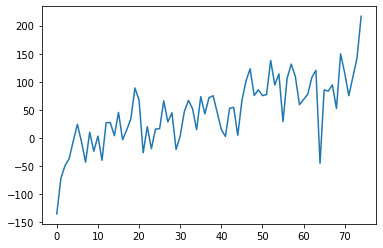

KeyboardInterrupt: 

In [10]:
from IPython.display import clear_output

mean_rewards = []

for i in range(1000):
    session_rewards = [agent.generate_session(train=True, batch_size=4) for _ in range(10)]
    mean_rewards.append(np.mean(session_rewards))
    agent.epsilon *= 0.99
    clear_output(True)
    print("epoch #{}\tmean reward = {:.3f}\tepsilon = {:.3f}".format(i, np.mean(session_rewards), agent.epsilon))
    plt.plot(mean_rewards)
    plt.show()
    #Save weights after every iteration
#     agent.save()
    if np.mean(session_rewards) > 200:
        print("You Win! Stop using Keyboard Interrupt")
#         break

In [11]:
agent.save()

In [12]:
# Record sessions
import gym.wrappers

with gym.wrappers.Monitor(gym.make("LunarLander-v2"), directory="videos", force=True) as env_monitor:
    agent.env = env_monitor
    sessions = [agent.generate_session(train=False) for _ in range(10)]

In [13]:
# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.

from pathlib import Path
from IPython.display import HTML

video_names = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(video_names[-1]))  # You can also try other indices